### DashForCash

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import duckdb

In [5]:
data_path = '../Mikey_data'
if os.path.exists(data_path):
    os.chdir(data_path)
    print(f'Change directory to data path: {data_path}')
else:
    print('Please point to the correct data path!')

Change directory to data path: ../Mikey_data


#### preprocessing data

In [7]:
# loading data

# standard CRSP exchange codes:
# 1 = NYSE
# 2 = AMEX
# 3 = NASDAQ
# 4 = NYSE Arca (includes SPY)
# 11 = NYSE MKT

con = duckdb.connect()

start_date = '2000-01-01'
end_date = '2014-01-01'

# Query:
# 1. join with delisting adjusted data
# 2. join with market data
# 3. filter by exchange
# 4. make sure the return is not null
query_data = (f"""
    SELECT 
    dsf.permno,
    dlycaldt  AS date,
    dlyret    AS ret,
    shrout    AS shares_outstanding,
    (shrout * dlyprc) AS market_cap,
    mkt_rf,
    rf,
    (ret - rf) AS ret_rf
    FROM read_parquet('crsp_202401.dsf_v2.parquet') AS dsf 
    JOIN (
        SELECT DISTINCT permno, hexcd AS exchange
        FROM read_parquet('crsp_202401.dsenames.parquet')
    ) AS exchanges
    ON dsf.permno = exchanges.permno
    JOIN (
        SELECT dt, mkt_rf, rf
        FROM read_parquet('ff.four_factor.parquet')
    ) AS mkt
    ON dsf.dlycaldt = mkt.dt
    WHERE dlycaldt BETWEEN '{start_date}' AND '{end_date}'
    AND exchange IN (1, 2, 3)
    AND dsf.dlyret IS NOT NULL
""")

crsp_d = con.execute(query_data).fetch_df()
crsp_d['date'] = pd.to_datetime(crsp_d['date'])
con.close()
crsp_d

,permno,date,ret,shares_outstanding,market_cap,mkt_rf,rf,ret_rf
0,89144,2002-02-12,0.000000,4,2.300000e+01,-0.0028,0.00007,-0.000070
1,89144,2002-02-13,0.000000,4,2.300000e+01,0.0099,0.00007,-0.000070
2,89144,2002-02-14,0.000000,4,2.300000e+01,-0.0024,0.00007,-0.000070
3,89144,2002-02-15,0.000000,4,2.300000e+01,-0.0112,0.00007,-0.000070
4,89144,2002-02-21,0.000000,4,2.300000e+01,-0.0152,0.00007,-0.000070
...,...,...,...,...,...,...,...,...
22831212,12214,2004-09-02,0.008368,6743,8.125315e+03,0.0109,0.00005,0.008318
22831213,83639,2013-12-31,0.003719,196436,1.266993e+07,0.0044,0.00000,0.003719
22831214,76712,2013-12-31,0.003458,722442,1.048263e+07,0.0044,0.00000,0.003458
22831215,88951,2002-08-06,-0.010481,3595,4.581827e+04,0.0303,0.00006,-0.010541


In [8]:
print(f'Number of unique permnos: {crsp_d["permno"].nunique()}')

Number of unique permnos: 13476


#### Run regressions to get beta - multi-process

In [9]:
# calculate the average of the rolling betas
def calc_rolling_beta(df: pd.DataFrame, window_size=60, step=1) -> dict:
    # use a rolling window approach with a fixed window size
    betas = {}
    
    for i in range(window_size, len(df), step):
        window_data = df.iloc[i - window_size:i]
        X = sm.add_constant(window_data['mkt_rf'])
        y = window_data['ret_rf']
        model = sm.OLS(y, X, missing='drop')
        results = model.fit()
        date_label = df.iloc[i]['date']
        betas[date_label] = results.params['mkt_rf']
         
    return betas

In [10]:
from joblib import Parallel, delayed
from tqdm import tqdm

# pre-filter groups with sufficient data
groups = [(permno, group) for permno, group in crsp_d.groupby('permno') if len(group) > 60]

# sort each group by date
groups = [(permno, group.sort_values(by='date')) for permno, group in groups]

def process_group(permno, group):
    return (permno, calc_rolling_beta(group))

# process in parallel with progress bar
results = Parallel(n_jobs=-1)(
    delayed(process_group)(permno, group) 
    for permno, group in tqdm(groups)
)

beta_dict = {permno: beta for permno, beta in results}

100%|██████████| 13123/13123 [16:33<00:00, 13.22it/s]


In [ ]:
# # saving beta_df to a file
# beta_df = pd.DataFrame.from_dict(beta_dict, orient="index").stack().reset_index()
# beta_df.columns = ["permno", "date", "beta"]
# beta_df.to_parquet('beta_df.parquet')

In [13]:
# reading beta_df from a file
beta_df = pd.read_parquet('beta_df.parquet')
beta_df

,permno,date,beta
0,10001,2000-03-29,-0.074486
1,10001,2000-03-30,-0.070324
2,10001,2000-03-31,-0.146655
3,10001,2000-04-03,-0.142490
4,10001,2000-04-04,-0.144885
...,...,...,...
22032533,14182,2013-12-31,0.466841
22032534,14196,2013-12-30,0.535516
22032535,14196,2013-12-31,0.574531
22032536,14221,2013-12-30,1.034773


In [14]:
# import duckdb

# con = duckdb.connect()
# con.execute(
# """
# WITH crsp_dsf AS (
# SELECT permno, dlycaldt AS date, dlyret AS ret, (shrout * dlyprc) AS market_cap
# FROM read_parquet('crsp_202401.dsf_v2.parquet')
# )
# SELECT beta_df.permno, beta_df.date, beta, crsp_dsf.ret, market_cap
# FROM read_parquet('beta_df.parquet') AS beta_df
# JOIN crsp_dsf
# ON beta_df.permno = crsp_dsf.permno
# AND beta_df.date = crsp_dsf.date
# """
# )

# beta_df = con.fetch_df()
# con.close()
# beta_df.to_parquet('beta_df.parquet')
# beta_df

,permno,date,beta,ret,market_cap
0,80778,2000-03-29,0.467289,-0.008197,534199.8750
1,80778,2000-03-30,0.470732,0.020661,545237.0625
2,80778,2000-03-31,0.450995,0.004049,547444.5000
3,80778,2000-04-03,0.451502,-0.004032,545237.0625
4,80778,2000-04-04,0.439767,0.016194,554066.8125
...,...,...,...,...,...
22032533,77964,2000-06-13,1.869253,-0.095057,367561.2500
22032534,11456,2001-09-26,-0.143082,0.000000,6976.0000
22032535,11456,2001-09-27,-0.158950,0.000000,6976.0000
22032536,11456,2001-09-28,-0.150455,0.000000,6982.4000


#### Decile Portfolios

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import duckdb

data_path = '../Mikey_data'
if os.path.exists(data_path):
    os.chdir(data_path)
    print(f'Change directory to data path: {data_path}')
else:
    print('Please point to the correct data path!')

Change directory to data path: ../Mikey_data


In [2]:
# Helper function to turn of the month identification
# Identify Trading Days Relative to Month End
# label trading days relative to month end
def label_trading_days(df):
    df = df.sort_values(['permno', 'date'])
    
    dates_labled = []
    
    dates_df = df.drop_duplicates(subset=['date'])[['date']].copy()
    dates_df['month'] = dates_df['date'].dt.to_period('M')

    # Initialize trading day labels
    dates_df['period_label'] = np.nan
    dates_df['period_label'] = dates_df['period_label'].astype(str)

    for month in tqdm(dates_df['month'].unique()):
        month_data = dates_df[dates_df['month'] == month]
        month_data.reset_index(drop=True, inplace=True)

        # handle corner cases: month data length not enough, cannot determine the trading day labels
        if len(month_data) < 10:
            continue
        # get around corner cases, where we don't have previous 8 days or next 8 days
        try:
            # start-of-month index in current month
            S_idx: int = month_data['date'].idxmin()
            # order matters, process 'T+1_T+4' first
            month_data.loc[list(range(S_idx, S_idx + 3)), 'period_label'] = 'T+1_T+3'
            month_data.loc[list(range(S_idx + 3, S_idx + 8)), 'period_label'] = 'T+4_T+8'
        except:
            pass

        try:
            # end-of-month index in current month
            T_idx: int = month_data['date'].idxmax()
            month_data.loc[T_idx, 'period_label'] = 'T'
            # order matters for the same reason
            month_data.loc[list(range(T_idx - 3, T_idx)), 'period_label'] = 'T-3_T-1'
            month_data.loc[list(range(T_idx - 8, T_idx - 3)), 'period_label'] = 'T-8_T-4'
        except:
            pass
            
        dates_labled.append(month_data)
            
    dates_labled_df = pd.concat(dates_labled, ignore_index=True)

    result_df = pd.merge(df, dates_labled_df[['date', 'period_label']], on='date', how='left')
    
    return result_df

In [3]:
# Helper function from Alan
def apply_quantiles(df, col, bins=10):
    """
    Assigns a quantile-based bin (1,...,bins) for each value in `col`
    within each date group.
    """
    def quantile_bin(s):
        # Use pd.qcut to get quantile bins; if duplicate edges occur, use rank instead.
        try:
            return pd.qcut(s, q=bins, labels=False, duplicates="drop") + 1
        except Exception:
            return np.ceil(s.rank(method='average') / len(s) * bins)
    return df.groupby('date')[col].transform(quantile_bin)

In [5]:
# label_trading_days(beta_df) # optional
beta_df = pd.read_parquet('beta_df.parquet')
beta_df = beta_df.sort_values(['permno', 'date'])

In [6]:
beta_df = label_trading_days(beta_df)

100%|██████████| 166/166 [00:00<00:00, 670.60it/s]


In [7]:
  # lag the market cap, using market cap value of the previous month last trading day
con = duckdb.connect()
con.execute(
"""
  WITH month_end AS (
      SELECT permno, LAST_DAY(LAST(date)) AS month_end_date,
      LAST(market_cap) AS mcap_lag
      FROM beta_df
      WHERE period_label IS NOT NULL
      AND market_cap IS NOT NULL
      GROUP BY permno, EXTRACT(YEAR FROM date), EXTRACT(MONTH FROM date)
  )
  SELECT beta_df.*, month_end.mcap_lag as mcap_lag
  FROM beta_df LEFT JOIN month_end
  ON beta_df.permno = month_end.permno
  AND month_end.month_end_date = LAST_DAY(beta_df.date - INTERVAL 1 MONTH)
  WHERE period_label IS NOT NULL
  AND period_label NOT LIKE '%nan%'
"""
)
beta_df = con.fetch_df()
con.close()
beta_df

,permno,date,beta,ret,market_cap,period_label,mcap_lag
0,24985,2002-11-01,0.531900,0.002475,6154542.00,T+1_T+3,6139345.6
1,24985,2002-11-04,0.541913,0.020988,6283711.40,T+1_T+3,6139345.6
2,24985,2002-11-05,0.548156,-0.007013,6239641.84,T+1_T+3,6139345.6
3,24985,2002-11-06,0.550036,0.004627,6268515.00,T+4_T+8,6139345.6
4,24985,2002-11-07,0.532870,-0.030303,6078560.00,T+4_T+8,6139345.6
...,...,...,...,...,...,...,...
17841623,92327,2008-01-31,0.602860,0.043982,293150.00,T,NaN
17841624,92328,2008-01-28,1.588482,0.005158,743555.68,T-3_T-1,NaN
17841625,92328,2008-01-29,1.525676,-0.030787,720664.00,T-3_T-1,NaN
17841626,92328,2008-01-30,1.660742,-0.067647,671913.20,T-3_T-1,NaN


In [12]:
from tqdm import tqdm

def apply_group_quantiles(group, col, bins=10):
    group['bin'] = apply_quantiles(group, col, bins=bins)
    return group

beta_df['month'] = beta_df['date'].dt.to_period('M')
tqdm.pandas(desc="Applying quantiles")

# want to assign quantiles within each month
beta_df = beta_df.groupby('month').progress_apply(lambda group: apply_group_quantiles(group, 'beta', bins=10)).reset_index(drop=True)

Applying quantiles: 100%|██████████| 165/165 [00:10<00:00, 15.07it/s]


In [16]:
bins = beta_df.groupby(['period_label', 'month', 'bin']).apply(
    lambda g: pd.Series({
        'EW': g['ret'].mean(),
        'VW': (g['ret'] * g['mcap_lag']).sum() / g['mcap_lag'].sum()
    })
).reset_index().groupby(['period_label', 'bin']).apply(
    lambda g: pd.Series({
        'EW': g['EW'].mean(),
        'VW': g['VW'].mean()
    })
).reset_index()

bins

/tmp/ipykernel_3038574/6030625.py:4: RuntimeWarning: invalid value encountered in scalar divide
  'VW': (g['ret'] * g['mcap_lag']).sum() / g['mcap_lag'].sum()
/tmp/ipykernel_3038574/6030625.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bins = beta_df.groupby(['period_label', 'month', 'bin']).apply(
/tmp/ipykernel_3038574/6030625.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).reset_index().group

,period_label,bin,EW,VW
0,T,1,0.004771,0.002246
1,T,2,0.003499,0.001537
2,T,3,0.003727,0.001003
3,T,4,0.003432,0.000561
4,T,5,0.003012,-0.000040
5,T,6,0.002810,0.000877
6,T,7,0.002416,0.000475
7,T,8,0.002707,0.000655
8,T,9,0.002713,0.000585
9,T,10,0.002626,0.001530


<Figure size 1000x600 with 0 Axes>

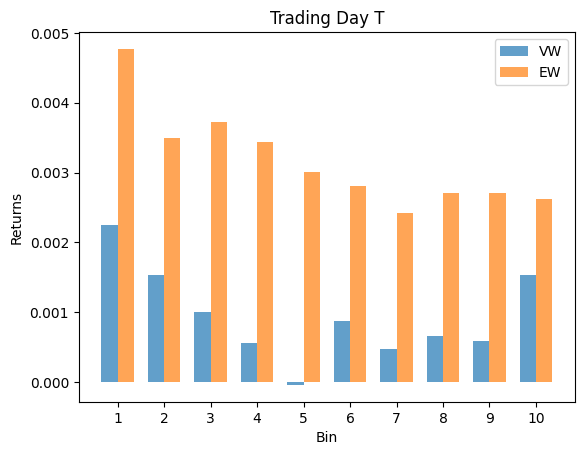

<Figure size 1000x600 with 0 Axes>

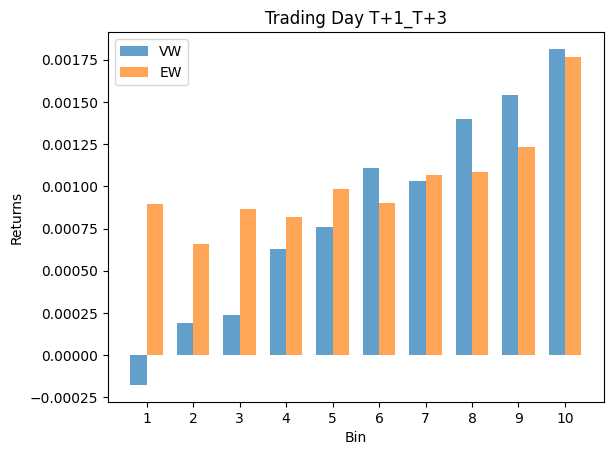

<Figure size 1000x600 with 0 Axes>

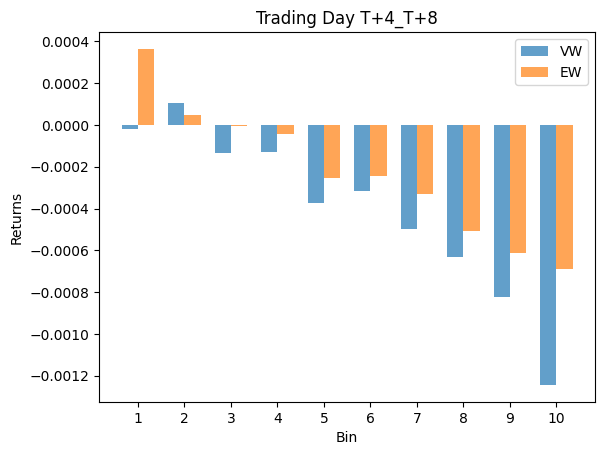

<Figure size 1000x600 with 0 Axes>

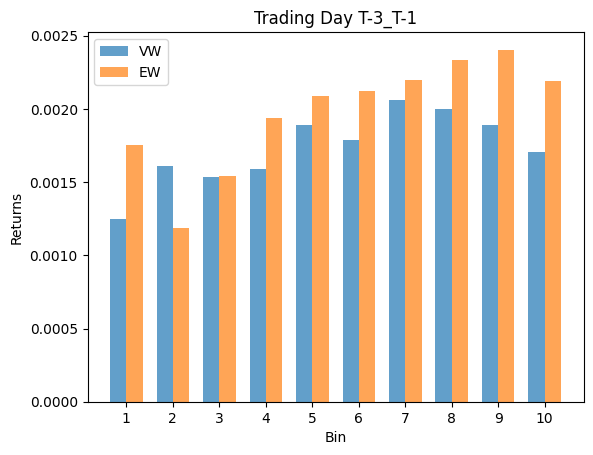

<Figure size 1000x600 with 0 Axes>

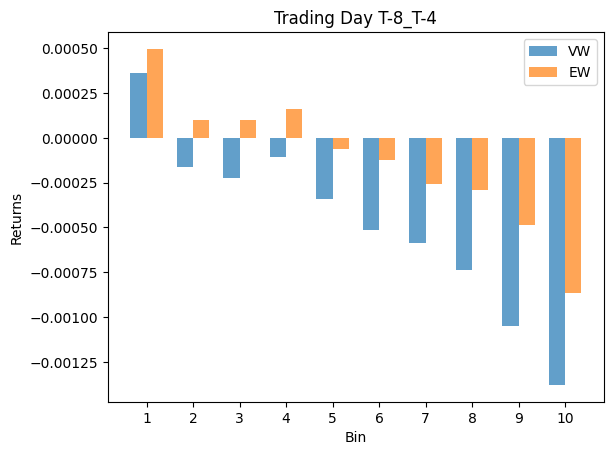

In [17]:
import numpy as np
import matplotlib.pyplot as plt

unique_period_label = bins['period_label'].unique()
num_days = len(unique_period_label)
width = 0.35  # Bar width

# Plot each trading day
for i, day in enumerate(unique_period_label, 1):
    plt.figure(figsize=(10, 6))  # Adjust the size as needed
    day_data = bins[bins['period_label'] == day]
    x = np.arange(len(day_data))  # Ensure x is a simple range of integers
    
    fig, ax = plt.subplots()
    
    # Plot the bars
    ax.bar(x - width/2, day_data['VW'], width, alpha=0.7, label='VW')
    ax.bar(x + width/2, day_data['EW'], width, alpha=0.7, label='EW')
    
    # Simplify the plot
    ax.set_xticks(x)
    ax.set_xticklabels(day_data['bin'].astype(str))  # Ensure proper x-tick labels
    ax.set_xlabel('Bin')
    ax.set_ylabel('Returns')
    ax.set_title(f'Trading Day {day}')
    ax.legend()
    
    plt.show()

#### Correlation Analysis

Correlation analysis on time-series returns between (selling pressure, positive reversal) pair, and (buying pressure, negative reversal) pair.

In [11]:
beta_df['month'] = beta_df['date'].dt.to_period('M')
beta_df.groupby(['month', 'period_label', 'bin']).apply(
  lambda g: pd.Series({
    'EW': g['ret'].mean(),
    'VW': (g['ret'] * g['mcap_lag']).sum() / g['mcap_lag'].sum()
  })
).reset_index().groupby('bin').apply(
  lambda g: pd.Series({
    'EW_T+1_T+3_T+4_T+8': g.pivot(index='month', columns='period_label', values='EW').corr().loc['T+1_T+3', 'T+4_T+8'],
    'EW_T-8_T-4_T-3_T-1': g.pivot(index='month', columns='period_label', values='EW').corr().loc['T-8_T-4', 'T-3_T-1'],
    'VW_T+1_T+3_T+4_T+8': g.pivot(index='month', columns='period_label', values='VW').corr().loc['T+1_T+3', 'T+4_T+8'],
    'VW_T-8_T-4_T-3_T-1': g.pivot(index='month', columns='period_label', values='VW').corr().loc['T-8_T-4', 'T-3_T-1'],
  })
)

/tmp/ipykernel_3038574/623166681.py:5: RuntimeWarning: invalid value encountered in scalar divide
  'VW': (g['ret'] * g['mcap_lag']).sum() / g['mcap_lag'].sum()
/tmp/ipykernel_3038574/623166681.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  beta_df.groupby(['month', 'period_label', 'bin']).apply(
/tmp/ipykernel_3038574/623166681.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).reset_index().groupb

,EW_T+1_T+3_T+4_T+8,EW_T-8_T-4_T-3_T-1,VW_T+1_T+3_T+4_T+8,VW_T-8_T-4_T-3_T-1
bin,,,,
1,0.409113,-0.193280,0.277656,-0.459874
2,0.295056,-0.408185,0.142021,-0.373044
3,0.249232,-0.454692,0.152185,-0.474792
4,0.202741,-0.428917,0.157498,-0.473584
5,0.152810,-0.344129,0.077071,-0.469091
